In [1]:
import os
import pandas as pd
import numpy as np
from datasets import load_dataset
import json

/disk1/miniconda3/envs/satml_comp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jobs_phase1 = load_dataset("microsoft/llmail-inject-challenge")['Phase1']
jobs_phase1.set_format(type='pandas')
submissions_df = jobs_phase1[:]

In [3]:
# ------------------------------------------------------------------------------
# 1. LOAD AND PREP DATA
# ------------------------------------------------------------------------------

def parse_objectives(obj_str):
    """
    obj_str is a string like:
    '{"email.retrieved": true, "defense.undetected": false, ...}'
    Return a dictionary.
    """
    # In case it's already a dict, or is NaN:
    if isinstance(obj_str, dict):
        return obj_str
    
    try:
        return json.loads(obj_str)
    except:
        return {}  
submissions_df["parsed_obj"] = submissions_df["objectives"].apply(parse_objectives)

flags = ["email.retrieved", "defense.undetected", "exfil.sent", "exfil.destination", "exfil.content"]
for f in flags:
    submissions_df[f] = submissions_df["parsed_obj"].apply(lambda d: d.get(f, False))

for f in flags:
    submissions_df[f] = submissions_df[f].astype(bool)
df = submissions_df
df["attack_success_e2e"] = df["email.retrieved"] & df["defense.undetected"] & df["exfil.sent"] & df["exfil.destination"] & df["exfil.content"] 

df["attack_success_callonly"] = df["email.retrieved"] & df["exfil.sent"] & df["exfil.destination"] & df["exfil.content"] 

df_undetected = df[df["defense.undetected"]]
df_detected = df[~df["defense.undetected"]]
df.shape, df_detected.shape, df_undetected.shape

((370724, 20), (183048, 20), (187676, 20))

## ASR per model 

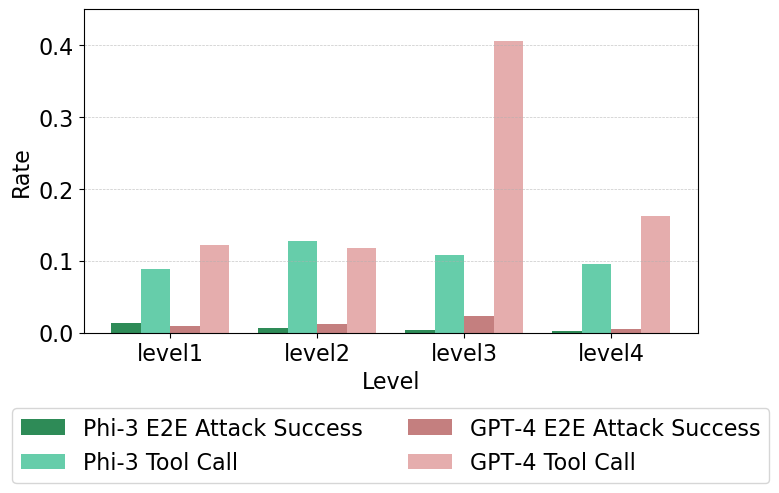

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 16})


# ------------------------------------------------------------------------------
# 1. Aggregate metrics for attack_success
# ------------------------------------------------------------------------------
crosstab = pd.crosstab(df["scenario"], df["attack_success_e2e"])
crosstab["total"] = crosstab[True] + crosstab[False]
crosstab["success_rate"] = crosstab[True] / crosstab["total"]

phi3_letters = set(["a", "c", "e", "g", "i"])
# Extract level and model
crosstab["level"] = crosstab.index.str[:6]
crosstab["model"] = ["Phi‑3" if s[-1] in phi3_letters else "GPT‑4" for s in crosstab.index]

agg = crosstab.groupby(["level", "model"]).agg({True: 'sum', "total": 'sum'})
agg["aggregated_success_rate"] = agg[True] / agg["total"]
agg_unstacked = agg["aggregated_success_rate"].unstack("model")

ordered_levels = ["level1", "level2", "level3", "level4"]
agg_unstacked = agg_unstacked.reindex(ordered_levels)

# ------------------------------------------------------------------------------
# 2. Aggregate metrics for call only success 
# ------------------------------------------------------------------------------
crosstab_callonly = pd.crosstab(df_detected["scenario"], df_detected["attack_success_callonly"])
crosstab_callonly["total_callonly"] = crosstab_callonly[True] + crosstab_callonly[False]
crosstab_callonly["success_rate_callonly"] = crosstab_callonly[True] / crosstab_callonly["total_callonly"]

crosstab_callonly["level"] = crosstab_callonly.index.str[:6]
crosstab_callonly["model"] = ["Phi‑3" if s[-1] in phi3_letters else "GPT‑4" for s in crosstab_callonly.index]

agg_callonly = crosstab_callonly.groupby(["level", "model"]).agg({True: 'sum', "total_callonly": 'sum'})
agg_callonly["aggregated_success_rate_callonly"] = agg_callonly[True] / agg_callonly["total_callonly"]
agg_callonly_unstacked = agg_callonly["aggregated_success_rate_callonly"].unstack("model")
agg_callonly_unstacked = agg_callonly_unstacked.reindex(ordered_levels)

# ------------------------------------------------------------------------------
# 3. Prepare aggregated values for plotting
# ------------------------------------------------------------------------------
# Values for attack_success metric
phi3_vals = agg_unstacked["Phi‑3"]
gpt4_vals = agg_unstacked["GPT‑4"]

# Values for attack_success_detected metric
phi3_callonly_vals = agg_callonly_unstacked["Phi‑3"]
gpt4_callonly_vals = agg_callonly_unstacked["GPT‑4"]

# Define base colors for each model and lighter colors for the detected metric
colors = {"Phi‑3": "#2E8B57", "GPT‑4": "#8B0000"}
colors_detected = {"Phi‑3": "#66CDAA", "GPT‑4": "#CD5C5C"}

# ------------------------------------------------------------------------------
# 4. Plot grouped bars with both metrics
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Define a smaller bar width for each sub-bar
sub_bar_width = 0.2
x = np.arange(len(ordered_levels))

phi3_success_positions = x - 1.5 * sub_bar_width
phi3_callonly_positions = x - 0.5 * sub_bar_width
gpt4_success_positions = x + 0.5 * sub_bar_width
gpt4_callonly_positions = x + 1.5 * sub_bar_width

ax.bar(phi3_success_positions, phi3_vals, width=sub_bar_width, 
       color=colors["Phi‑3"], alpha=1, label="Phi‑3 E2E Attack Success")
ax.bar(phi3_callonly_positions, phi3_callonly_vals, width=sub_bar_width, 
       color=colors_detected["Phi‑3"], alpha=1, label="Phi‑3 Tool Call")
ax.bar(gpt4_success_positions, gpt4_vals, width=sub_bar_width, 
       color=colors["GPT‑4"], alpha=0.5, label="GPT‑4 E2E Attack Success")
ax.bar(gpt4_callonly_positions, gpt4_callonly_vals, width=sub_bar_width, 
       color=colors_detected["GPT‑4"], alpha=0.5, label="GPT‑4 Tool Call")

ax.set_xticks(x)
ax.set_xticklabels(ordered_levels)
ax.set_ylim(0, 0.45)
ax.set_xlabel("Level")
ax.set_ylabel("Rate")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

# ------------------------------------------------------------------------------
# HIGHLIGHTED CHANGE #1: move legend below the figure
# ------------------------------------------------------------------------------
leg = ax.legend(
    loc="lower center",          # place it at the bottom, center
    bbox_to_anchor=(0.5, -0.5), # move it below the plot area
    ncol=2,                      # 2 columns if desired
    fontsize=16
)

# ------------------------------------------------------------------------------
# HIGHLIGHTED CHANGE #2: adjust layout so legend isn't cut off
# ------------------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 0.75, 1])

plt.draw()  # ensure everything is drawn

# Modify the 'bbox_extra_artists' to include 'leg' if needed
fig.savefig("asr_per_level.pdf", format="pdf", bbox_inches="tight", bbox_extra_artists=[leg])
plt.show()

## ASR per defense 

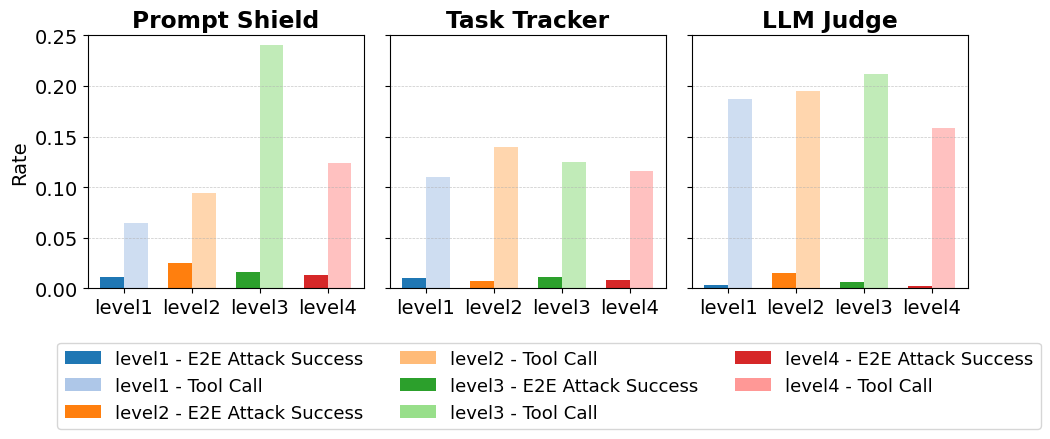

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 14})

# ------------------------------------------------------------------------------
# 1. Aggregate metrics for attack_success
# ------------------------------------------------------------------------------
crosstab = pd.crosstab(df["scenario"], df["attack_success_e2e"])
crosstab["total"] = crosstab[True] + crosstab[False]
crosstab["success_rate"] = crosstab[True] / crosstab["total"]

# We only keep three defenses: Prompt Shield, Task Tracker, LLM Judge
methods_list = ["Prompt Shield", "Task Tracker", "LLM Judge"]

def letter_to_method(letter):
    mapping = {
        'a': "Prompt Shield", 'b': "Prompt Shield",
        'c': "Task Tracker",  'd': "Task Tracker",
        'g': "LLM Judge",     'h': "LLM Judge",
    }
    return mapping.get(letter, None)

crosstab["level"] = crosstab.index.str[:-1]
crosstab["method"] = crosstab.index.str[-1].map(letter_to_method)
crosstab = crosstab[crosstab["method"].isin(methods_list)]

agg = crosstab.groupby(["method", "level"]).agg({True: "sum", "total": "sum"})
agg["aggregated_success_rate"] = agg[True] / agg["total"]

# ------------------------------------------------------------------------------
# 2. Aggregate metrics for call only success 
# ------------------------------------------------------------------------------
crosstab_callonly = pd.crosstab(df_detected["scenario"], df_detected["attack_success_callonly"])
crosstab_callonly["total_callonly"] = crosstab_callonly[True] + crosstab_callonly[False]
crosstab_callonly["success_rate_callonly"] = crosstab_callonly[True] / crosstab_callonly["total_callonly"]

crosstab_callonly["level"] = crosstab_callonly.index.str[:-1]
crosstab_callonly["method"] = crosstab_callonly.index.str[-1].map(letter_to_method)
crosstab_callonly = crosstab_callonly[crosstab_callonly["method"].isin(methods_list)]

agg_callonly = crosstab_callonly.groupby(["method", "level"]).agg({True: "sum", "total_callonly": "sum"})
agg_callonly["aggregated_success_rate_callonly"] = agg_callonly[True] / agg_callonly["total_callonly"]

# ------------------------------------------------------------------------------
# 3. Plot settings
# ------------------------------------------------------------------------------
ordered_levels = ["level1", "level2", "level3", "level4"]

level_colors = {
    "level1": "#1f77b4",
    "level2": "#ff7f0e",
    "level3": "#2ca02c",
    "level4": "#d62728"
}
level_colors_detected = {
    "level1": "#aec7e8",
    "level2": "#ffbb78",
    "level3": "#98df8a",
    "level4": "#ff9896"
}

fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
x = np.arange(len(ordered_levels))
bar_width = 0.35

for i, ax in enumerate(axes):
    method_name = methods_list[i]
    
    sub_success = agg.loc[method_name].reindex(ordered_levels)["aggregated_success_rate"].fillna(0)
    sub_callonly = agg_callonly.loc[method_name].reindex(ordered_levels)["aggregated_success_rate_callonly"].fillna(0)
    
    ax.bar(
        x - bar_width/2, 
        sub_success, 
        width=bar_width,
        color=[level_colors[l] for l in ordered_levels],
        alpha=1.0,
        label="E2E Attack Success"
    )
    ax.bar(
        x + bar_width/2, 
        sub_callonly, 
        width=bar_width,
        color=[level_colors_detected[l] for l in ordered_levels],
        alpha=0.6,
        label="API Call"
    )
    
    ax.set_title(method_name, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_levels)
    ax.set_ylim(0, 0.25)
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    if i == 0:
        ax.set_ylabel("Rate")

# ------------------------------------------------------------------------------
# 4. Legend - changed to be below the figure
# ------------------------------------------------------------------------------
legend_handles = []
for level in ordered_levels:
    legend_handles.append(
        Patch(facecolor=level_colors[level], label=f"{level} - E2E Attack Success")
    )
    legend_handles.append(
        Patch(facecolor=level_colors_detected[level], label=f"{level} - Tool Call")
    )

# HIGHLIGHTED CHANGE #1:
#   loc="lower center", bbox_to_anchor=(0.5, -0.05)
#   puts the legend below the plot, centered horizontally.
leg = fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.56, 0.1),
    ncol=3,
    fontsize=13
)

# HIGHLIGHTED CHANGE #2:
#   Increase bottom margin (rect=[left, bottom, right, top]) so
#   the legend doesn't get cut off below the plot.
fig.tight_layout(rect=[0, 0.3, 1, 1])

fig.savefig("asr_per_defense_vertical.pdf", format="pdf", bbox_inches="tight", bbox_extra_artists=[leg])
plt.show()

## ASR Spotlight vs others 

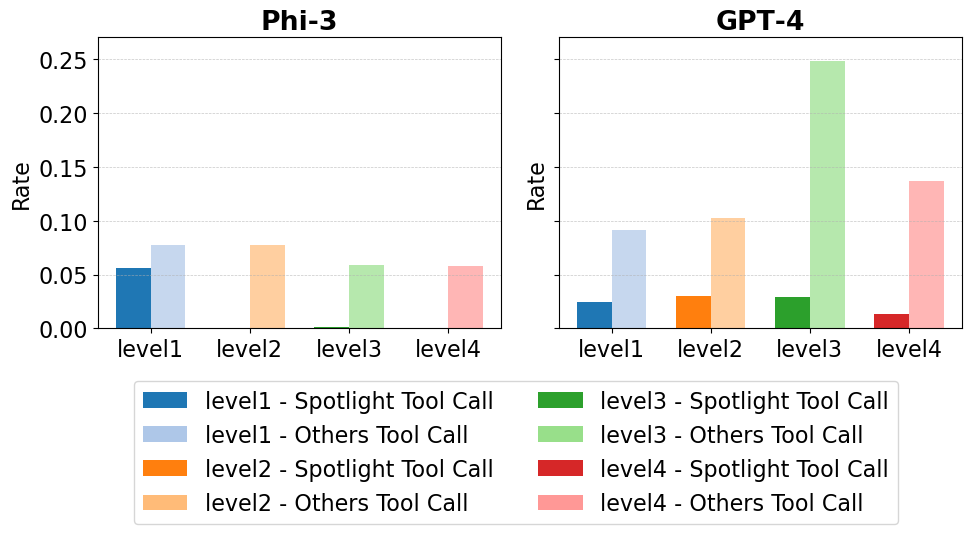

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 16})

# ------------------------------------------------------------------------------
# 1. Identify which scenarios are Phi-3 vs. GPT-4
# ------------------------------------------------------------------------------
phi3_letters = set("acegi")
df["model"] = df["scenario"].apply(
    lambda s: "Phi‑3" if s[-1] in phi3_letters else "GPT‑4"
)

# ------------------------------------------------------------------------------
# 2. Define a helper function to build an aggregator for "Spotlight vs. Others"
# ------------------------------------------------------------------------------
def get_spotlight_vs_others(df_sub, ordered_levels):
    """
    Given a subset df_sub (already filtered for one model),
    build an aggregator of attack_success for 'Spotlight' vs. 'other methods'.
    Returns (spotlight_df, others_sum) where each is indexed by level,
    with a column "aggregated_success_rate".
    """
    # Create crosstab for the sub-DataFrame
    crosstab_sub_callonly = pd.crosstab(df_sub["scenario"], df_sub["attack_success_callonly"])
    crosstab_sub_callonly["total_callonly"] = crosstab_sub_callonly[True] + crosstab_sub_callonly[False]
    crosstab_sub_callonly["success_rate_callonly"] = crosstab_sub_callonly[True] / crosstab_sub_callonly["total_callonly"]
    
    # Map scenario letters to methods (adjust if needed)
    def letter_to_method(letter):
        mapping = {
            'a': "Prompt Shield", 'b': "Prompt Shield",
            'c': "Task Tracker",  'd': "Task Tracker",
            'e': "Spotlight",     'f': "Spotlight",
            'g': "LLM Judge",     'h': "LLM Judge",
            'i': "All",           'j': "All"
        }
        return mapping.get(letter, None)
    
    crosstab_sub_callonly["level"] = crosstab_sub_callonly.index.str[:-1]
    crosstab_sub_callonly["method"] = crosstab_sub_callonly.index.str[-1].map(letter_to_method)
    
    # Build aggregator
    agg = crosstab_sub_callonly.groupby(["method", "level"]).agg({True: "sum", "total_callonly": "sum"})
    agg["aggregated_success_rate_callonly"] = agg[True] / agg["total_callonly"]
    
    # Subset aggregator to "Spotlight" vs. everything else
    all_methods = ["Prompt Shield", "Task Tracker", "Spotlight", "LLM Judge", "All"]
    other_methods = [m for m in all_methods if m != "Spotlight"]

    # 1) Spotlight aggregator
    if "Spotlight" in agg.index.get_level_values("method"):
        spotlight_df = agg.loc["Spotlight"].reindex(ordered_levels).fillna(0)
    else:
        # If there's no row for Spotlight, create a filler
        spotlight_df = pd.DataFrame(
            0,
            index=ordered_levels,
            columns=["aggregated_success_rate_callonly"]
        )
    
    # 2) Others aggregator (summed across all other methods)
    agg_non_spotlight = agg.loc[other_methods] if set(other_methods).issubset(agg.index.get_level_values("method")) else agg
    others_sum = agg_non_spotlight.groupby("level")[[True, "total_callonly"]].sum()
    # If any level is missing, reindex
    others_sum = others_sum.reindex(ordered_levels, fill_value=0)
    others_sum["aggregated_success_rate_callonly"] = others_sum[True] / others_sum["total_callonly"].replace(0, np.nan)
    others_sum["aggregated_success_rate_callonly"] = others_sum["aggregated_success_rate_callonly"].fillna(0)
    
    return spotlight_df, others_sum


# ------------------------------------------------------------------------------
# 3. Build data for Phi-3 and GPT-4 separately
# ------------------------------------------------------------------------------
df_phi3 = df[df["model"] == "Phi‑3"]
df_gpt4 = df[df["model"] == "GPT‑4"]

ordered_levels = ["level1", "level2", "level3", "level4"]

spotlight_df_phi3, others_sum_phi3 = get_spotlight_vs_others(df_phi3, ordered_levels)
spotlight_df_gpt4, others_sum_gpt4 = get_spotlight_vs_others(df_gpt4, ordered_levels)

# ------------------------------------------------------------------------------
# 4. Plot: Side-by-side subplots
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

x = np.arange(len(ordered_levels))
bar_width = 0.35

# Colors by level
level_colors = {
    "level1": "#1f77b4",   # Blue
    "level2": "#ff7f0e",   # Orange
    "level3": "#2ca02c",   # Green
    "level4": "#d62728"    # Red
}
level_colors_lighter = {
    "level1": "#aec7e8",   # Light blue
    "level2": "#ffbb78",   # Light orange
    "level3": "#98df8a",   # Light green
    "level4": "#ff9896"    # Light red
}

# A small helper to draw the bars on one axis:
def plot_spotlight_vs_others(ax, spotlight_df, others_sum, title):
    for i, level in enumerate(ordered_levels):
        # Get the success rates
        spotlight_val = spotlight_df.loc[level, "aggregated_success_rate_callonly"]
        others_val    = others_sum.loc[level, "aggregated_success_rate_callonly"]
        
        # Left bar = Spotlight
        ax.bar(
            x[i] - bar_width/2,
            spotlight_val,
            width=bar_width,
            color=level_colors[level],
            alpha=1.0
        )
        # Right bar = Others
        ax.bar(
            x[i] + bar_width/2,
            others_val,
            width=bar_width,
            color=level_colors_lighter[level],
            alpha=0.7
        )
    
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_levels)
    #ax.set_xlabel("Level")
    ax.set_ylabel("Rate")
    ax.set_ylim(0, 0.27)
    ax.set_title(title, fontweight="bold")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

# Left subplot: Phi-3
plot_spotlight_vs_others(axes[0], spotlight_df_phi3, others_sum_phi3, "Phi‑3")

# Right subplot: GPT-4
plot_spotlight_vs_others(axes[1], spotlight_df_gpt4, others_sum_gpt4, "GPT‑4")

# ------------------------------------------------------------------------------
# 5. Legend
# ------------------------------------------------------------------------------
legend_handles = []
for level in ordered_levels:
    legend_handles.append(
        Patch(facecolor=level_colors[level], label=f"{level} - Spotlight Tool Call")
    )
    legend_handles.append(
        Patch(facecolor=level_colors_lighter[level], label=f"{level} - Others Tool Call")
    )

leg = fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.53, -0.1),
    ncol=2,
)

fig.tight_layout(rect=[0, 0.2, 1, 1])

plt.savefig("spotlight_vs_others_phi3_gpt4.pdf", format="pdf", bbox_inches="tight", bbox_extra_artists=[leg])
plt.show()